# Mood Classifier Using ConvNet



## *Importing the Packages*

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)


## *Load the Data and Split the Data into Train/Test Sets*

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


*We can display images in the dataset, images are 64x64 in RGB format*

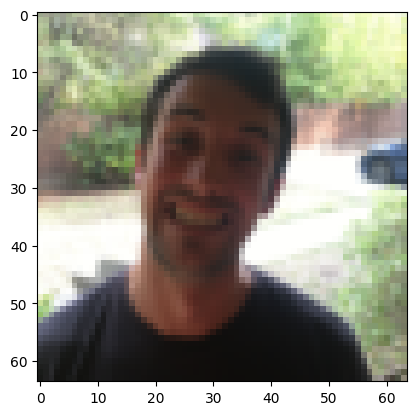

In [ ]:
index=5
# display sample image from train dataset
plt.imshow(X_train_orig[index])
plt.show()

## Layers in TF Keras

TF Keras has predefined layers that we can apply, these just take the input and transforms into output that we can reuse later.

## The Sequential API
We can use TF Keras Sequential API which is pretty easy to create layers and each layer takes an input tensor and produces an output tensor.

### Create the Sequential Model
You can also add layers incrementally to a Sequential model with the .add() method, or remove them using the .pop() method, much like you would in a regular Python list.

Actually, you can think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters. If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!

For any layer construction in Keras, you'll need to specify the input shape in advance. This is because in Keras, the shape of the weights is based on the shape of the inputs. The weights are only created when the model first sees some input data. Sequential models can be created by passing a list of layers to the Sequential constructor.

We will create a happyModel function below to build the following model: ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE.

Plugging in the following parameters for all the steps:

* ZeroPadding2D: padding 3,
* input shape 64 x 64 x 3
* Conv2D: Use 32 7x7 filters, stride 1
* BatchNormalization: for axis 3
* ReLU
* MaxPool2D: Using default parameters
* Flatten the previous output.
* Fully-connected (Dense) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation.

* tfl: tf.keras.layers

In [ ]:
def happyModel():
  model=tf.keras.Sequential([
      # ZeroPadding2D with padding 3, input shape of 64x64x3
      tfl.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 3)),
      ## Conv2D with 32 7x7 filters and stride of 1
      tfl.Conv2D(32, (7, 7)),
      # BatchNormalization for axis 3
      tfl.BatchNormalization(axis=-1),
      ## RelU
      tfl.ReLU(),
      # Max Pooling 2D with default parameters
      tfl.MaxPool2D(),
      ## Flatten Layer
      tfl.Flatten(),
      ## Dense layer with 1 unit for output & 'sigmoid' activation
      tfl.Dense(units=1, activation='sigmoid')
    ])
  return model

Now that our model is created, we can compile it for training with an optimizer and loss of your choice. When the string accuracy is specified as a metric, the type of accuracy used will be automatically converted based on the loss function used. This is one of the many optimizations built into TensorFlow that make your life easier!

In [ ]:
happy_model=happyModel()

happy_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

It's time to check our model's parameters with the .summary() method. This will display the types of layers you have, the shape of the outputs, and how many parameters are in each layer.

In [ ]:
# Print a summary for each layer
happy_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d_11               │ (None, 70, 70, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 64 (256.00 B)

### Train and Evaluate the Model

After creating the model, compiling it with your choice of optimizer and loss function, and doing a sanity check on its contents, you are now ready to build!

Simply call .fit() to train. That's it! No need for mini-batching, saving, or complex backpropagation computations. That's all been done for you, as you're using a TensorFlow dataset with the batches specified already. You do have the option to specify epoch number or minibatch size if you like (for example, in the case of an un-batched dataset).

In [ ]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5944 - loss: 1.9444
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8092 - loss: 0.4984
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.9215 - loss: 0.1738
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9521 - loss: 0.1572
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9665 - loss: 0.1017
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9687 - loss: 0.0970
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9450 - loss: 0.1378
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9695 - loss: 0.0748
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9787 - loss: 0.0654
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9849 - loss: 0.0460


After that completes, just use .evaluate() to evaluate against your test set. This function will print the value of the loss function and the performance metrics specified during the compilation of the model. In this case, the binary_crossentropy and the accuracy respectively.

In [ ]:
happy_model.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9711 - loss: 0.1170


[0.10634264349937439, 0.9666666388511658]